In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as datetime

In [2]:
data_base = "data/"
path_audusd = data_base + "AUDUSD.csv"
path_eurusd = data_base + "EURUSD.csv"
path_sp = data_base + "SP.csv"
path_btcusdt = data_base + "BTCUSDT.csv"
path_dogeusdt = data_base + "DOGEUSDT.csv"

In [3]:
window_size = 2 * 7 * 24

In [4]:
def load_data(file_path, add_zigzag_col=True):
    data = pd.read_csv(file_path)
    if add_zigzag_col:
        data["zigzag"] = 0
    return data

In [5]:
def handle_zigzag(df):
    df_indices = df[df.RelativeIndice!=0]
    
    base_indices = df_indices.index.to_numpy()
    relative_indices = df_indices.RelativeIndice.to_numpy()
    zigzag_values = df_indices.HighOrLow.to_numpy()
    
    target_indices = base_indices - relative_indices
    mask = target_indices >= 0

    target_indices = target_indices[mask]
    zigzag_values = zigzag_values[mask]
    assert len(target_indices) == len(zigzag_values)
    
    df.loc[target_indices, "zigzag"] = zigzag_values

In [6]:
def label_data(df):
    labeling_data = df[df.zigzag!=0]
    limit_indices = labeling_data.index.to_numpy()
    core_labels = labeling_data.zigzag.to_numpy()
    core_values = np.select([labeling_data['zigzag'] == 1, labeling_data['zigzag'] == -1],
                            [labeling_data["high"], labeling_data["low"]], 
                            default=np.nan)
    
    values_list = list()
    labels_list = list()
    limit_indices = np.append(np.array([0]), limit_indices)
    for i in range(len(limit_indices) - 1):
        low_idx = limit_indices[i]
        high_idx = limit_indices[i + 1]
        values_list.extend([core_values[i]]*(high_idx-low_idx))
        labels_list.extend([core_labels[i]]*(high_idx-low_idx))
    
    values_list = np.array(values_list)
    values_list = np.append(values_list, np.full(len(df) - len(labels_list), np.nan))
    labels_list = np.array(labels_list)
    labels_list = np.append(labels_list, np.full(len(df) - len(labels_list), np.nan))
    
    df["label"] = labels_list
    df["value"] = values_list

In [7]:
def generate_vpvr(df, num_of_bins):
    """
    Calculates VPVR on the on the df
    
    """

    # last_bars_data = df.iloc[-num_of_bars:]
    last_bars_data = df
    assert len(last_bars_data) <= 168
    range_high = last_bars_data['high'].max()
    range_low = last_bars_data['low'].min()
    range_height = range_high - range_low

    low_list = [range_low + range_height * i / num_of_bins for i in range(num_of_bins)]
    high_list = [range_low + range_height * (i + 1) / num_of_bins for i in range(num_of_bins)]
    mid_list = [(low + high) / 2 for low, high in zip(low_list, high_list)]

    buy_volume_list = np.zeros(num_of_bins)
    sell_volume_list = np.zeros(num_of_bins)

    for index, row in last_bars_data.iterrows():
        current_bar_height = row['high'] - row['low']
        current_buy_volume = 0 if current_bar_height == 0 else row['volume'] * (row['close'] - row['low']) / current_bar_height
        current_sell_volume = 0 if current_bar_height == 0 else row['volume'] * (row['high'] - row['close']) / current_bar_height
        
        for j in range(num_of_bins):
            histogram_low = low_list[j]
            histogram_high = high_list[j]
            target = max(histogram_high, row['high']) - min(histogram_low, row['low']) \
                     - (max(histogram_high, row['high']) - min(histogram_high, row['high'])) \
                     - (max(histogram_low, row['low']) - min(histogram_low, row['low']))
            histogram_volume_percentage = target / current_bar_height if current_bar_height != 0 else 0

            if histogram_volume_percentage > 0:
                buy_volume_list[j] += current_buy_volume * histogram_volume_percentage
                sell_volume_list[j] += current_sell_volume * histogram_volume_percentage

    #scale the values between 0 - 1
    total_vol = (buy_volume_list.sum() + sell_volume_list.sum())
    buy_volume_list = buy_volume_list / total_vol
    sell_volume_list = sell_volume_list / total_vol
    
    return buy_volume_list, sell_volume_list

    """
    hist_column_width = range_height/num_of_bins
    plt.figure(figsize=(12, 8))
    for i in range(num_of_bins):
        plt.bar(mid_list[i], buy_volume_list[i], color='green', width=hist_column_width)
        plt.bar(mid_list[i], -sell_volume_list[i], color='red', width=hist_column_width)
        
    plt.show()    
    """


In [8]:
aud_usd = load_data(path_audusd, True)
handle_zigzag(aud_usd)
aud_usd.drop(["Volume MA", "RelativeIndice", "HighOrLow"], axis=1, inplace=True)
aud_usd = aud_usd[['time', 'open', 'high', 'low', 'close', 'Volume', 'zigzag']]
aud_usd.columns = ['time', 'open', 'high', 'low', 'close', 'volume', 'zigzag']
aud_usd.head()

,time,open,high,low,close,volume,zigzag
0,2020-01-02T08:00:00+02:00,0.70162,0.70162,0.69995,0.70000,24,0
1,2020-01-02T09:00:00+02:00,0.70000,0.70026,0.69971,0.70005,3776,0
2,2020-01-02T10:00:00+02:00,0.70005,0.70065,0.69993,0.70057,4889,0
3,2020-01-02T11:00:00+02:00,0.70057,0.70059,0.69960,0.69975,4250,0
4,2020-01-02T12:00:00+02:00,0.69975,0.69995,0.69912,0.69968,3764,0


In [9]:
aud_usd['time'] = pd.to_datetime(aud_usd['time'], utc=True)
aud_usd['time'] = aud_usd['time'].dt.tz_convert('Etc/GMT-2')
aud_usd.head()

,time,open,high,low,close,volume,zigzag
0,2020-01-02 08:00:00+02:00,0.70162,0.70162,0.69995,0.70000,24,0
1,2020-01-02 09:00:00+02:00,0.70000,0.70026,0.69971,0.70005,3776,0
2,2020-01-02 10:00:00+02:00,0.70005,0.70065,0.69993,0.70057,4889,0
3,2020-01-02 11:00:00+02:00,0.70057,0.70059,0.69960,0.69975,4250,0
4,2020-01-02 12:00:00+02:00,0.69975,0.69995,0.69912,0.69968,3764,0


In [10]:
label_data(aud_usd)
aud_usd.head()

,time,open,high,low,close,volume,zigzag,label,value
0,2020-01-02 08:00:00+02:00,0.70162,0.70162,0.69995,0.70000,24,0,-1.0,0.6849
1,2020-01-02 09:00:00+02:00,0.70000,0.70026,0.69971,0.70005,3776,0,-1.0,0.6849
2,2020-01-02 10:00:00+02:00,0.70005,0.70065,0.69993,0.70057,4889,0,-1.0,0.6849
3,2020-01-02 11:00:00+02:00,0.70057,0.70059,0.69960,0.69975,4250,0,-1.0,0.6849
4,2020-01-02 12:00:00+02:00,0.69975,0.69995,0.69912,0.69968,3764,0,-1.0,0.6849


In [11]:
aud_usd.tail()

,time,open,high,low,close,volume,zigzag,label,value
24893,2023-12-29 19:00:00+02:00,0.68269,0.68388,0.68256,0.68351,7811,0,NaN,NaN
24894,2023-12-29 20:00:00+02:00,0.68351,0.68351,0.68195,0.68208,8934,0,NaN,NaN
24895,2023-12-29 21:00:00+02:00,0.68208,0.68217,0.68083,0.68141,5673,0,NaN,NaN
24896,2023-12-29 22:00:00+02:00,0.68141,0.68191,0.68117,0.68153,3046,0,NaN,NaN
24897,2023-12-29 23:00:00+02:00,0.68153,0.68153,0.68078,0.68102,1626,0,NaN,NaN


In [12]:
aud_usd = aud_usd[aud_usd.value.notna()]
print(aud_usd.shape)
assert aud_usd.shape[0] == (aud_usd.index[-1] + 1)
aud_usd.tail()

(24760, 9)


,time,open,high,low,close,volume,zigzag,label,value
24755,2023-12-20 19:00:00+02:00,0.67632,0.67688,0.67585,0.67665,5992,0,-1.0,0.67232
24756,2023-12-20 20:00:00+02:00,0.67665,0.67694,0.67635,0.67652,5587,0,-1.0,0.67232
24757,2023-12-20 21:00:00+02:00,0.67652,0.67652,0.67416,0.67467,7999,0,-1.0,0.67232
24758,2023-12-20 22:00:00+02:00,0.67467,0.67468,0.67252,0.67254,13598,0,-1.0,0.67232
24759,2023-12-20 23:00:00+02:00,0.67254,0.67334,0.67241,0.67299,3643,0,-1.0,0.67232


In [13]:
assert len(aud_usd[aud_usd.isna().any(axis=1)]) == 0

In [14]:
# metadata: 
# - vpvr (on prev week)

# - prew weekly high
# - prew weekly low
# - prew weekly open
# - prew weekly close
# - monday open
# - monday high
# - monday low
# - monday close

# - bias vector
# - 2 category (weekend, weekday{\Monday})


In [65]:
class HourlyDataset(Dataset):
    # metadata:
    # - vpvr (on prev week)

    # - prev weekly high
    # - prev weekly low
    # - prev weekly open
    # - prev weekly close
    # - monday open
    # - monday high
    # - monday low
    # - monday close

    # - bias vector
    # - 2 category (weekend, weekday{\Monday})
    def __init__(self, ltf_data, window_size, split=None):
        super(HourlyDataset, self).__init__()
        # at the end of init:
        # ltf_data:
        # ltf_candles:
        #    ['open', 'high', 'low', 'close', 'volume'] 'time' 'week_idx' 'usable' 'weekday'
        # weekly_data:
        #    ['pw_high', 'pw_low', 'pw_open', 'pw_close', 'mon_open', 'mon_high', 'mon_low', 'mon_close', 'vpvr']
        # usable_ltf_candles:
        #    ["week_idx", "weekday"]

        self.split = split
        self.ltf_data = ltf_data.copy()
        self.ltf_candles = self.ltf_data[["open", "high", "low", "close", "volume", "time"]].copy()
        self.labels = self.ltf_data[["label", "value"]].copy()

        self.weekly_data = self._extract_weekly_info(self.ltf_candles)
        self.window_size = window_size

        self._handle_weekly_none()                      # for weekly
        self._mark_usable_or_not()                      # for ltf_candles
        self._guarantee_overlap_weekly_and_candles()    # for weekly and ltf_candles

        self._control_indices(self.ltf_candles)
        self.usable_ltf_candles = self.ltf_candles[self.ltf_candles.usable == 1][["week_idx", "weekday"]].copy()
        self.usable_ltf_candles = self._handle_consistent_split(self.usable_ltf_candles, self.split)  # handle split

        self._drop_unnecessary_and_order_ltf()  # for ltf_candles
        self._order_weekly_data()               # for weekly
        self.ltf_candles = self.ltf_candles.to_numpy()  # for efficiency

    def __len__(self):
        return len(self.usable_ltf_candles)

    def __getitem__(self, idx):
        """
        :return:
        x            -> numpy array: window_size * OHLCV
        metadata[2:] -> numpy array: ['pw_open', 'pw_close', 'mon_open', 'mon_high', 'mon_low', 'mon_close', 'vpvr']
        label        -> numpy array: [direction, value]
        weekday      -> int: 1 if weekday, 0 if weekend
        """
        # return candle_seq, metadata (about the week), labels, weekday info
        #
        last_candle = self.usable_ltf_candles.iloc[idx]
        weekday = last_candle.weekday
        idx_in_df = last_candle.name

        # x -> row_idx * OHLCV
        x = self.ltf_candles[idx_in_df - (self.window_size - 1): idx_in_df + 1].copy()
        weekly_info = self.weekly_data.loc[last_candle.week_idx].to_numpy().copy()
        label = self.labels.loc[idx_in_df].to_numpy().copy()

        # normalize x and metadata components
        self._normalize_data_metadata_label(x, weekly_info, label)

        return x, weekly_info[2:], label, weekday

    def _normalize_data_metadata_label(self, x, metadata, label):
        # x -> row * OHLCV
        # metadata -> series obj with
        #     ['pw_high', 'pw_low', 'pw_open', 'pw_close', 'mon_open', 'mon_high', 'mon_low', 'mon_close', 'vpvr']
        # label -> label, value

        # take the pw_high and pw_low -> index:
        #           OHLC of x;
        #           'pw_open', 'pw_close', 'mon_open', 'mon_high', 'mon_low', 'mon_close' of metadata;
        #           value of label.
        pw_high = metadata[0]
        pw_low = metadata[1]
        pw_mid = (pw_low + pw_high) / 2
        pw_half_range = (pw_high - pw_low) / 2

        x[:, :4] = (x[:, :4] - pw_mid) / pw_half_range
        metadata[2: 8] = (metadata[2: 8] - pw_mid) / pw_half_range
        label[1] = (label[1] - pw_mid) / pw_half_range

        # standardize the volume
        mean_vol = np.mean(x[:, -1])
        std_vol = np.std(x[:, -1])
        x[:, -1] = (x[:, -1] - mean_vol) / std_vol

    def _handle_consistent_split(self, data, split):
        # 0.7 - 0.2 - 0.1 for train - dev - test
        if split is None:
            return data

        random_state = 42
        train_prop = 0.7
        dev_prop = 0.2
        test_prop = 0.1

        dev_remain = dev_prop / (test_prop + dev_prop)
        test_remain = test_prop / (test_prop + dev_prop)

        unique_week_indices = pd.Series(data.week_idx.unique())
        train_weeks = unique_week_indices.sample(frac=train_prop, random_state=random_state)
        if split == "train":
            return data[data['week_idx'].isin(train_weeks)].copy()

        unique_week_indices = unique_week_indices[~unique_week_indices.isin(train_weeks)]
        dev_weeks = unique_week_indices.sample(frac=dev_remain, random_state=random_state)
        if split == "dev":
            return data[data['week_idx'].isin(dev_weeks)].copy()

        unique_week_indices = unique_week_indices[~unique_week_indices.isin(dev_weeks)]
        test_weeks = unique_week_indices
        if split == "test":
            return data[data['week_idx'].isin(test_weeks)].copy()

        assert False, "Split should be 'train', 'dev', or 'test'"

    """
        def _handle_consistent_split(self, data, split):
        # 0.7 - 0.2 - 0.1 for train - dev - test
        if split is None:
            return data

        random_state = 42
        train_prop = 0.7
        dev_prop = 0.2
        test_prop = 0.1

        dev_remain = dev_prop / (test_prop + dev_prop)
        test_remain = test_prop / (test_prop + dev_prop)

        train_split = data.sample(frac=train_prop, random_state=random_state)
        if split == "train":
            return train_split

        train_idx = train_split.index
        dev_test_data = data.drop(train_idx, axis=0)
        dev_split = dev_test_data.sample(frac=dev_remain, random_state=random_state)
        if split == "dev":
            return dev_split

        dev_idx = dev_split.index
        test_split = dev_test_data.drop(dev_idx, axis=0)
        if split == "test":
            return test_split

        assert False, "Split should be 'train', 'dev', or 'test'"
    """


    def _order_weekly_data(self):
        order = ['pw_high', 'pw_low', 'pw_open', 'pw_close', 'mon_open', 'mon_high', 'mon_low', 'mon_close', 'vpvr']
        self.weekly_data = self.weekly_data[order]

    def _drop_unnecessary_and_order_ltf(self):
        keep_id = ["open", "high", "low", "close", "volume"]
        for col in self.ltf_candles.columns:
            if col not in keep_id:
                self.ltf_candles.drop(col, inplace=True, axis=1)

        # also order the columns
        self.ltf_candles = self.ltf_candles[keep_id]

    def _control_indices(self, df):
        is_ordered = df.index.equals(pd.RangeIndex(start=0, stop=len(df)))
        assert is_ordered, "The indices must not be corrupted!"

    def _handle_weekly_none(self):
        while self.weekly_data.iloc[0].isna().any():
            self.weekly_data = self.weekly_data.iloc[1:]

        while self.weekly_data.iloc[-1].isna().any():
            self.weekly_data = self.weekly_data.iloc[:-1]

        if len(self.weekly_data[self.weekly_data.isna().any(axis=1)]) > 0:
            print(self.weekly_data[self.weekly_data.isna().any(axis=1)])
            assert False, "Weekly data contains None values!"

    def _guarantee_overlap_weekly_and_candles(self):
        # assumes no None value in weekly data
        idx_array = self.ltf_candles[self.ltf_candles.usable == 1].week_idx.unique()
        weekly_idx_array = self.weekly_data.index.to_numpy()
        for idx in idx_array:
            if idx not in weekly_idx_array:
                print(idx)
                assert False, "Found a nonexisting week in weekly data"

    def _mark_usable_or_not(self):
        # policy of not usable:
        # if monday or among first (window_size - 1) candles, then not usable
        # also marks whether weekday or weekend
        self.ltf_candles["usable"] = self.ltf_candles.apply \
            (lambda row: 0 if (row.name < (self.window_size - 1) or row["time"].weekday() == 0) else 1, axis=1)
        self.ltf_candles["weekday"] = self.ltf_candles.apply(lambda row: 0 if row["time"].weekday() > 4 else 1, axis=1)

    def _extract_weekly_info(self, hourly_candles):
        time_idx_candles = hourly_candles.set_index("time", inplace=False)

        # Monday ohlc
        monday_data = time_idx_candles[time_idx_candles.index.weekday == 0]
        monday_ohlc = monday_data.resample("W-MON").agg({
            "open": "first",
            "high": "max",
            "low": "min",
            "close": "last"
        })
        monday_ohlc.index = monday_ohlc.index.strftime('%Y-%m-%d')
        monday_ohlc.columns = ["mon_open", "mon_high", "mon_low", "mon_close"]

        # weekly hlc
        weekly_data = time_idx_candles.resample("W-SUN").agg({
            "open": "first",
            "high": "max",
            "low": "min",
            "close": "last"})
        weekly_data.index = weekly_data.index + pd.Timedelta(days=1)
        weekly_data.index = weekly_data.index.strftime("%Y-%m-%d")
        weekly_data.columns = ["pw_open", "pw_high", "pw_low", "pw_close"]

        if (len(weekly_data) - len(monday_ohlc)) > 1:
            assert False

        weekly_data = pd.merge(weekly_data, monday_ohlc, left_index=True, right_index=True, how='outer')

        # VPVR
        vpvr_series = pd.Series(dtype=object)
        num_bins = 10

        # Create week specific index
        # indices are monday date as str for compatibility with other df's
        time_idx_candles["week_idx"] = \
            (time_idx_candles.index - pd.to_timedelta(time_idx_candles.index.weekday, unit='D')).strftime(
                "%Y-%m-%d")
        # also add the week_idx column to the original data for later usage
        hourly_candles["week_idx"] = (
                hourly_candles.time - pd.to_timedelta(hourly_candles.time.dt.weekday, unit='D')).dt.strftime(
            "%Y-%m-%d")

        for week_idx in time_idx_candles['week_idx'].unique():
            # current week
            weekly_box = time_idx_candles[time_idx_candles['week_idx'] == week_idx]

            if not weekly_box.empty:
                buy_array, sell_array = generate_vpvr(weekly_box, num_bins)
                # concatenate buy and sell arrays
                vpvr_series.at[week_idx] = np.concatenate([buy_array, sell_array])

        return pd.merge(weekly_data, vpvr_series.rename("vpvr"), left_index=True, right_index=True, how='outer')

    @staticmethod
    def get_collate_fn():
        def hourly_collate_fn(batch):
            x = [item[0] for item in batch]
            metadata = [item[1] for item in batch]
            label = [item[2] for item in batch]
            weekday = [item[3] for item in batch]

            for idx, met in enumerate(metadata):
                metadata[idx] = np.concatenate((met[0:-1], met[-1]))

            # Convert lists to PyTorch tensors
            x_tensor = torch.tensor(x, dtype=torch.float32)  # shape: [BS, seq_len, OHLCV]
            metadata_tensor = torch.tensor(metadata, dtype=torch.float32)  # shape: [BS, metadata_dim]
            label_tensor = torch.tensor(label, dtype=torch.float32)  # shape: [BS, 2]
            weekday_tensor = torch.tensor(weekday, dtype=torch.float32)  # shape: [BS]

            return x_tensor, metadata_tensor, label_tensor, weekday_tensor

        return hourly_collate_fn

In [66]:
dataset_train = HourlyDataset(aud_usd, window_size, "train")
dataset_dev = HourlyDataset(aud_usd, window_size, "dev")
dataset_test = HourlyDataset(aud_usd, window_size, "test")

In [78]:
ls = [dataset[i][2][1] for i in range(len(dataset))]

In [79]:
len(ls)

19546

In [80]:
max(ls)

5.592686002522087

In [81]:
min(ls)

-10.812211390456644

In [127]:
dataset.ltf_data

,time,open,high,low,close,volume,zigzag,label,value
0,2020-01-02 08:00:00+02:00,0.70162,0.70162,0.69995,0.70000,24,0,-1.0,0.68490
1,2020-01-02 09:00:00+02:00,0.70000,0.70026,0.69971,0.70005,3776,0,-1.0,0.68490
2,2020-01-02 10:00:00+02:00,0.70005,0.70065,0.69993,0.70057,4889,0,-1.0,0.68490
3,2020-01-02 11:00:00+02:00,0.70057,0.70059,0.69960,0.69975,4250,0,-1.0,0.68490
4,2020-01-02 12:00:00+02:00,0.69975,0.69995,0.69912,0.69968,3764,0,-1.0,0.68490
...,...,...,...,...,...,...,...,...,...
24755,2023-12-20 19:00:00+02:00,0.67632,0.67688,0.67585,0.67665,5992,0,-1.0,0.67232
24756,2023-12-20 20:00:00+02:00,0.67665,0.67694,0.67635,0.67652,5587,0,-1.0,0.67232
24757,2023-12-20 21:00:00+02:00,0.67652,0.67652,0.67416,0.67467,7999,0,-1.0,0.67232
24758,2023-12-20 22:00:00+02:00,0.67467,0.67468,0.67252,0.67254,13598,0,-1.0,0.67232


In [128]:
cpy_ltf_data = dataset.ltf_data.copy()

In [139]:
cpy_ltf_data["week_idx"] = (
        cpy_ltf_data.time - pd.to_timedelta(cpy_ltf_data.time.dt.weekday, unit='D')).dt.strftime(
        "%Y-%m-%d")

In [145]:
zigzag_cpy_ltf_data = cpy_ltf_data[cpy_ltf_data.zigzag!=0]

In [188]:
zigzag_extracted_cpy_ltf_data = zigzag_cpy_ltf_data[["value", "week_idx"]]

In [189]:
zigzag_extracted_cpy_ltf_data

,value,week_idx
105,0.69199,2020-01-06
165,0.68772,2020-01-13
223,0.69337,2020-01-13
247,0.68270,2020-01-13
331,0.68789,2020-01-20
...,...,...
24607,0.65396,2023-12-11
24608,0.67352,2023-12-11
24699,0.66903,2023-12-18
24705,0.67791,2023-12-18


In [148]:
dataset.weekly_data

,pw_high,pw_low,pw_open,pw_close,mon_open,mon_high,mon_low,mon_close,vpvr
2020-01-06,0.70162,0.69303,0.70162,0.69448,0.69410,0.69576,0.69254,0.69395,"[0.07139851621088784, 0.12014916352459169, 0.1..."
2020-01-13,0.69576,0.68490,0.69410,0.68997,0.68970,0.69199,0.68931,0.69030,"[0.006402194660719989, 0.010770886966259946, 0..."
2020-01-20,0.69337,0.68705,0.68970,0.68730,0.68731,0.68885,0.68552,0.68724,"[0.017585315313212325, 0.009002650250484386, 0..."
2020-01-27,0.68885,0.68176,0.68731,0.68247,0.68120,0.68185,0.67520,0.67609,"[0.042659864666248035, 0.04500502888548604, 0...."
2020-02-03,0.68185,0.66829,0.68120,0.66866,0.66835,0.67072,0.66835,0.66917,"[0.010683061114418996, 0.034981475536011566, 0..."
...,...,...,...,...,...,...,...,...,...
2023-11-20,0.65419,0.63473,0.63503,0.65136,0.64992,0.65651,0.64992,0.65562,"[0.006033639688436224, 0.006716503651569259, 0..."
2023-11-27,0.65910,0.64992,0.64992,0.65794,0.65749,0.66141,0.65668,0.66063,"[0.014083158034471275, 0.02218649138242142, 0...."
2023-12-04,0.66764,0.65668,0.65749,0.66708,0.66637,0.66906,0.66048,0.66194,"[0.010774584259205943, 0.04490772539062159, 0...."
2023-12-11,0.66906,0.65253,0.66637,0.65725,0.65668,0.65829,0.65499,0.65674,"[0.0877328413508935, 0.08370555009360693, 0.04..."


In [193]:
for row in zigzag_extracted_cpy_ltf_data.iterrows():
    week_idx = row[1].week_idx
    value = row[1].value - ((dataset.weekly_data.loc[week_idx]["pw_high"] + dataset.weekly_data.loc[week_idx]["pw_low"]) / 2)
    value = value / (((dataset.weekly_data.loc[week_idx]["pw_high"] - dataset.weekly_data.loc[week_idx]["pw_low"]) / 2))
    row[1].value = value
    zigzag_extracted_cpy_ltf_data.loc[row[0]] = row[1]

/Users/fatih/opt/anaconda3/envs/comp541/lib/python3.7/site-packages/pandas/core/indexing.py:1797: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)


In [197]:
zigzag_extracted_cpy_ltf_data

-10.812211390456644

In [198]:
zigzag_extracted_cpy_ltf_data_vals = zigzag_extracted_cpy_ltf_data.value

In [194]:
dataset.usable_ltf_candles

,week_idx,weekday
335,2020-01-20,1
336,2020-01-20,1
337,2020-01-20,1
338,2020-01-20,1
339,2020-01-20,1
...,...,...
24755,2023-12-18,1
24756,2023-12-18,1
24757,2023-12-18,1
24758,2023-12-18,1


In [177]:
zigzag_extracted_cpy_ltf_data = zigzag_extracted_cpy_ltf_data[["value", "week_idx"]]

In [175]:
zigzag_extracted_cpy_ltf_data

,value,week_idx,base,105
105,0.004295,2020-01-06,0,NaN
165,0.687720,2020-01-13,0,NaN
223,0.693370,2020-01-13,0,NaN
247,0.682700,2020-01-13,0,NaN
331,0.687890,2020-01-20,0,NaN
...,...,...,...,...
24607,0.653960,2023-12-11,0,NaN
24608,0.673520,2023-12-11,0,NaN
24699,0.669030,2023-12-18,0,NaN
24705,0.677910,2023-12-18,0,NaN


In [187]:
zigzag_cpy_ltf_data[["value", "week_idx"]]

,value,week_idx
105,0.69199,2020-01-06
165,0.68772,2020-01-13
223,0.69337,2020-01-13
247,0.68270,2020-01-13
331,0.68789,2020-01-20
...,...,...
24607,0.65396,2023-12-11
24608,0.67352,2023-12-11
24699,0.66903,2023-12-18
24705,0.67791,2023-12-18


In [143]:
cpy_ltf_data[cpy_ltf_data.zigzag!=0]

,time,open,high,low,close,volume,zigzag,label,value,week_idx
105,2020-01-08 17:00:00+02:00,0.68577,0.68603,0.68490,0.68550,7487,-1,1.0,0.69199,2020-01-06
165,2020-01-13 05:00:00+02:00,0.69148,0.69199,0.69142,0.69166,7122,1,-1.0,0.68772,2020-01-13
223,2020-01-15 15:00:00+02:00,0.68908,0.68919,0.68772,0.68851,7527,-1,1.0,0.69337,2020-01-13
247,2020-01-16 15:00:00+02:00,0.69281,0.69337,0.69210,0.69227,8767,1,-1.0,0.68270,2020-01-13
331,2020-01-22 03:00:00+02:00,0.68364,0.68391,0.68270,0.68320,13614,-1,1.0,0.68789,2020-01-20
...,...,...,...,...,...,...,...,...,...,...
24607,2023-12-12 15:00:00+02:00,0.65875,0.66123,0.65569,0.65592,27255,1,-1.0,0.65396,2023-12-11
24608,2023-12-12 16:00:00+02:00,0.65592,0.65745,0.65396,0.65488,20766,-1,1.0,0.67352,2023-12-11
24699,2023-12-18 11:00:00+02:00,0.67256,0.67352,0.67239,0.67293,6958,1,-1.0,0.66903,2023-12-18
24705,2023-12-18 17:00:00+02:00,0.67206,0.67220,0.66903,0.66936,12643,-1,1.0,0.67791,2023-12-18


In [137]:
dataset.ltf_data.loc[cpy_ltf_data[cpy_ltf_data.zigzag!=0].index]

,time,open,high,low,close,volume,zigzag,label,value
105,2020-01-08 17:00:00+02:00,0.68577,0.68603,0.68490,0.68550,7487,-1,1.0,0.69199
165,2020-01-13 05:00:00+02:00,0.69148,0.69199,0.69142,0.69166,7122,1,-1.0,0.68772
223,2020-01-15 15:00:00+02:00,0.68908,0.68919,0.68772,0.68851,7527,-1,1.0,0.69337
247,2020-01-16 15:00:00+02:00,0.69281,0.69337,0.69210,0.69227,8767,1,-1.0,0.68270
331,2020-01-22 03:00:00+02:00,0.68364,0.68391,0.68270,0.68320,13614,-1,1.0,0.68789
...,...,...,...,...,...,...,...,...,...
24607,2023-12-12 15:00:00+02:00,0.65875,0.66123,0.65569,0.65592,27255,1,-1.0,0.65396
24608,2023-12-12 16:00:00+02:00,0.65592,0.65745,0.65396,0.65488,20766,-1,1.0,0.67352
24699,2023-12-18 11:00:00+02:00,0.67256,0.67352,0.67239,0.67293,6958,1,-1.0,0.66903
24705,2023-12-18 17:00:00+02:00,0.67206,0.67220,0.66903,0.66936,12643,-1,1.0,0.67791


In [ ]:
cpy_ltf_data[cpy_ltf_data.zigzag!=0].index

In [136]:
dataset.weekly_data

,pw_high,pw_low,pw_open,pw_close,mon_open,mon_high,mon_low,mon_close,vpvr
2020-01-06,0.70162,0.69303,0.70162,0.69448,0.69410,0.69576,0.69254,0.69395,"[0.07139851621088784, 0.12014916352459169, 0.1..."
2020-01-13,0.69576,0.68490,0.69410,0.68997,0.68970,0.69199,0.68931,0.69030,"[0.006402194660719989, 0.010770886966259946, 0..."
2020-01-20,0.69337,0.68705,0.68970,0.68730,0.68731,0.68885,0.68552,0.68724,"[0.017585315313212325, 0.009002650250484386, 0..."
2020-01-27,0.68885,0.68176,0.68731,0.68247,0.68120,0.68185,0.67520,0.67609,"[0.042659864666248035, 0.04500502888548604, 0...."
2020-02-03,0.68185,0.66829,0.68120,0.66866,0.66835,0.67072,0.66835,0.66917,"[0.010683061114418996, 0.034981475536011566, 0..."
...,...,...,...,...,...,...,...,...,...
2023-11-20,0.65419,0.63473,0.63503,0.65136,0.64992,0.65651,0.64992,0.65562,"[0.006033639688436224, 0.006716503651569259, 0..."
2023-11-27,0.65910,0.64992,0.64992,0.65794,0.65749,0.66141,0.65668,0.66063,"[0.014083158034471275, 0.02218649138242142, 0...."
2023-12-04,0.66764,0.65668,0.65749,0.66708,0.66637,0.66906,0.66048,0.66194,"[0.010774584259205943, 0.04490772539062159, 0...."
2023-12-11,0.66906,0.65253,0.66637,0.65725,0.65668,0.65829,0.65499,0.65674,"[0.0877328413508935, 0.08370555009360693, 0.04..."


In [135]:
cpy_ltf_data[cpy_ltf_data.zigzag!=0].value

105      0.69199
165      0.68772
223      0.69337
247      0.68270
331      0.68789
          ...   
24607    0.65396
24608    0.67352
24699    0.66903
24705    0.67791
24753    0.67232
Name: value, Length: 607, dtype: float64

In [133]:
cpy_ltf_data[cpy_ltf_data.zigzag!=0].index

Int64Index([  105,   165,   223,   247,   331,   356,   435,   453,   508,
              579,
            ...
            24490, 24502, 24525, 24539, 24583, 24607, 24608, 24699, 24705,
            24753],
           dtype='int64', length=607)

In [129]:
dataset.usable_ltf_candles

,week_idx,weekday
335,2020-01-20,1
336,2020-01-20,1
337,2020-01-20,1
338,2020-01-20,1
339,2020-01-20,1
...,...,...
24755,2023-12-18,1
24756,2023-12-18,1
24757,2023-12-18,1
24758,2023-12-18,1


In [130]:
dataset.ltf_data[dataset.ltf_data.zigzag != 0].iloc[5:10]

,time,open,high,low,close,volume,zigzag,label,value
356,2020-01-23 04:00:00+02:00,0.68722,0.68789,0.68711,0.68755,9247,1,-1.0,0.67370
435,2020-01-28 11:00:00+02:00,0.67427,0.67490,0.67370,0.67471,7773,-1,1.0,0.67773
453,2020-01-29 05:00:00+02:00,0.67698,0.67773,0.67683,0.67762,5322,1,-1.0,0.66829
508,2020-01-31 12:00:00+02:00,0.66888,0.66952,0.66829,0.66918,5683,-1,1.0,0.67743
579,2020-02-05 11:00:00+02:00,0.67601,0.67743,0.67578,0.67713,11723,1,-1.0,0.66622


In [82]:
ls = np.array(ls)

In [100]:
ls_unique = np.unique(ls)

In [101]:
ls_unique.size

704

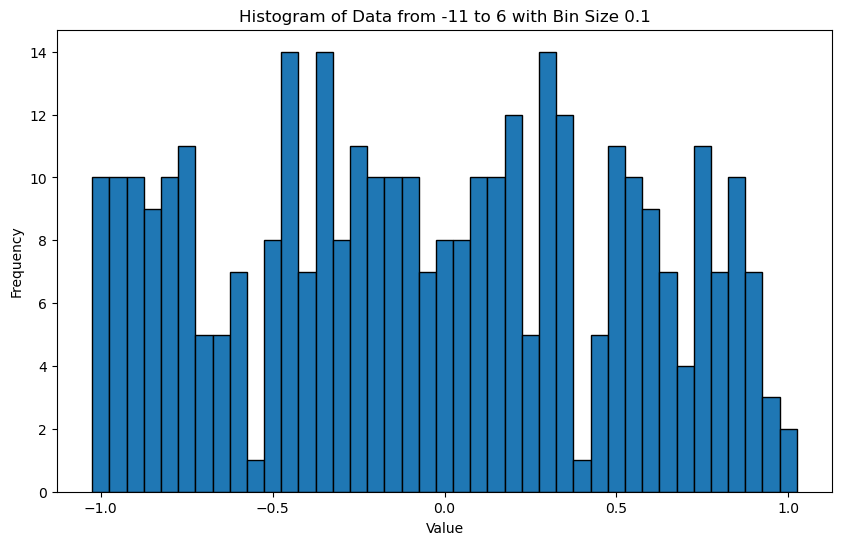

In [204]:
# Example data (replace this with your actual data)
data = zigzag_extracted_cpy_ltf_data_vals

# Define the bins
bin_size = 0.05
bins = np.arange(-1.025, 1.025 + bin_size, bin_size)  # bins from -11 to 6 with a step of 0.2

# Calculate the histogram
hist, bin_edges = np.histogram(data, bins)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist, width=bin_size, edgecolor='black', align='edge')

xticks = np.arange(-1, 1.1, 0.5)  # Ticks from -11 to 6 at every 0.5 units

plt.xticks(xticks)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data from -11 to 6 with Bin Size 0.1')
plt.show()


In [ ]:
ls.hist

In [74]:
dataset[0][0]

array([[ 3.61075949,  3.61075949,  3.08227848,  3.09810127, -1.53980733],
       [ 3.09810127,  3.18037975,  3.00632911,  3.11392405, -0.49862936],
       [ 3.11392405,  3.30379747,  3.07594937,  3.27848101, -0.18977246],
       ...,
       [-1.87341772, -1.82594937, -1.98417722, -1.91455696,  0.36605895],
       [-1.91455696, -1.83544304, -2.07911392, -2.01582278, -0.36459712],
       [-2.01582278, -1.87025316, -2.01898734, -1.90506329,  0.17652682]])

In [76]:
dataset[0][2][1]

-0.7341772151898579

In [207]:
aud_usd.loc[[0,3,5]]

,time,open,high,low,close,volume,zigzag,label,value
0,2020-01-02 08:00:00+02:00,0.70162,0.70162,0.69995,0.70000,24,0,-1.0,0.6849
3,2020-01-02 11:00:00+02:00,0.70057,0.70059,0.69960,0.69975,4250,0,-1.0,0.6849
5,2020-01-02 13:00:00+02:00,0.69968,0.69971,0.69830,0.69845,5042,0,-1.0,0.6849


In [67]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset_train, batch_size=1, shuffle=False, collate_fn=HourlyDataset.get_collate_fn())

In [60]:
dataset_train.usable_ltf_candles

,week_idx,weekday
335,2020-01-20,1
336,2020-01-20,1
337,2020-01-20,1
338,2020-01-20,1
339,2020-01-20,1
...,...,...
24683,2023-12-11,1
24684,2023-12-11,1
24685,2023-12-11,1
24686,2023-12-11,1


In [69]:
dataset_test.usable_ltf_candles

,week_idx,weekday
1145,2020-03-09,1
1146,2020-03-09,1
1147,2020-03-09,1
1148,2020-03-09,1
1149,2020-03-09,1
...,...,...
24755,2023-12-18,1
24756,2023-12-18,1
24757,2023-12-18,1
24758,2023-12-18,1


In [55]:
aud_usd[aud_usd.time <= aud_usd.loc[1].time]

,time,open,high,low,close,volume,zigzag,label,value
0,2020-01-02 08:00:00+02:00,0.70162,0.70162,0.69995,0.70000,24,0,-1.0,0.6849
1,2020-01-02 09:00:00+02:00,0.70000,0.70026,0.69971,0.70005,3776,0,-1.0,0.6849


In [56]:
aud_usd[aud_usd.zigzag != 0].time.

,time,open,high,low,close,volume,zigzag,label,value
105,2020-01-08 17:00:00+02:00,0.68577,0.68603,0.68490,0.68550,7487,-1,1.0,0.69199
165,2020-01-13 05:00:00+02:00,0.69148,0.69199,0.69142,0.69166,7122,1,-1.0,0.68772
223,2020-01-15 15:00:00+02:00,0.68908,0.68919,0.68772,0.68851,7527,-1,1.0,0.69337
247,2020-01-16 15:00:00+02:00,0.69281,0.69337,0.69210,0.69227,8767,1,-1.0,0.68270
331,2020-01-22 03:00:00+02:00,0.68364,0.68391,0.68270,0.68320,13614,-1,1.0,0.68789
...,...,...,...,...,...,...,...,...,...
24607,2023-12-12 15:00:00+02:00,0.65875,0.66123,0.65569,0.65592,27255,1,-1.0,0.65396
24608,2023-12-12 16:00:00+02:00,0.65592,0.65745,0.65396,0.65488,20766,-1,1.0,0.67352
24699,2023-12-18 11:00:00+02:00,0.67256,0.67352,0.67239,0.67293,6958,1,-1.0,0.66903
24705,2023-12-18 17:00:00+02:00,0.67206,0.67220,0.66903,0.66936,12643,-1,1.0,0.67791


In [53]:
aud_usd.loc[1].time

Timestamp('2020-01-02 09:00:00+0200', tz='Etc/GMT-2')

In [51]:
aud_usd

,time,open,high,low,close,volume,zigzag,label,value
0,2020-01-02 08:00:00+02:00,0.70162,0.70162,0.69995,0.70000,24,0,-1.0,0.68490
1,2020-01-02 09:00:00+02:00,0.70000,0.70026,0.69971,0.70005,3776,0,-1.0,0.68490
2,2020-01-02 10:00:00+02:00,0.70005,0.70065,0.69993,0.70057,4889,0,-1.0,0.68490
3,2020-01-02 11:00:00+02:00,0.70057,0.70059,0.69960,0.69975,4250,0,-1.0,0.68490
4,2020-01-02 12:00:00+02:00,0.69975,0.69995,0.69912,0.69968,3764,0,-1.0,0.68490
...,...,...,...,...,...,...,...,...,...
24755,2023-12-20 19:00:00+02:00,0.67632,0.67688,0.67585,0.67665,5992,0,-1.0,0.67232
24756,2023-12-20 20:00:00+02:00,0.67665,0.67694,0.67635,0.67652,5587,0,-1.0,0.67232
24757,2023-12-20 21:00:00+02:00,0.67652,0.67652,0.67416,0.67467,7999,0,-1.0,0.67232
24758,2023-12-20 22:00:00+02:00,0.67467,0.67468,0.67252,0.67254,13598,0,-1.0,0.67232


In [52]:
dataset_train.usable_ltf_candles

,week_idx,weekday
335,2020-01-20,1
336,2020-01-20,1
337,2020-01-20,1
338,2020-01-20,1
339,2020-01-20,1
...,...,...
24683,2023-12-11,1
24684,2023-12-11,1
24685,2023-12-11,1
24686,2023-12-11,1


In [49]:
aud_usd[aud_usd.zigzag!=0].shape

(607, 9)

In [44]:
len(dataset_train.usable_ltf_candles)

13790

In [46]:
dataset_train.usable_ltf_candles.week_idx

335      2020-01-20
336      2020-01-20
337      2020-01-20
338      2020-01-20
339      2020-01-20
            ...    
24683    2023-12-11
24684    2023-12-11
24685    2023-12-11
24686    2023-12-11
24687    2023-12-11
Name: week_idx, Length: 13790, dtype: object

In [45]:
len(dataset_train.usable_ltf_candles.week_idx.unique())

144

In [17]:
a, b, c, d = dataset[0]

In [18]:
a

array([[ 3.61075949,  3.61075949,  3.08227848,  3.09810127, -1.53980733],
       [ 3.09810127,  3.18037975,  3.00632911,  3.11392405, -0.49862936],
       [ 3.11392405,  3.30379747,  3.07594937,  3.27848101, -0.18977246],
       ...,
       [-1.87341772, -1.82594937, -1.98417722, -1.91455696,  0.36605895],
       [-1.91455696, -1.83544304, -2.07911392, -2.01582278, -0.36459712],
       [-2.01582278, -1.87025316, -2.01898734, -1.90506329,  0.17652682]])

In [19]:
a.shape

(336, 5)

In [20]:
b

array([-0.1613924050632918, -0.9208860759493419, -0.9177215189873311,
       -0.43037974683544483, -1.4841772151898402, -0.9398734177215126,
       array([0.01758532, 0.00900265, 0.0478506 , 0.11463756, 0.05714069,
              0.04989508, 0.06661868, 0.0658207 , 0.03195058, 0.02357034,
              0.01425883, 0.0181804 , 0.0403105 , 0.1068201 , 0.06902782,
              0.04855184, 0.08569988, 0.08053719, 0.03983393, 0.01270731])],
      dtype=object)

In [21]:
b.shape

(7,)

In [22]:
c

array([ 1.        , -0.73417722])

In [23]:
d

1

In [26]:
k = np.zeros((2,2,2))
l = [np.zeros((2,2)), np.zeros((2,2))]

In [28]:
torch.tensor(l).shape

torch.Size([2, 2, 2])

In [25]:
torch.tensor(k)

tensor([[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]], dtype=torch.float64)